In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv
/kaggle/input/playground-series-s3e3/sample_submission.csv
/kaggle/input/playground-series-s3e3/train.csv
/kaggle/input/playground-series-s3e3/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import xgboost as xgb
import lightgbm as lgbm
import catboost
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e3/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e3/test.csv')
extra_df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [4]:
train_df.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1677 non-null   int64 
 1   Age                       1677 non-null   int64 
 2   BusinessTravel            1677 non-null   object
 3   DailyRate                 1677 non-null   int64 
 4   Department                1677 non-null   object
 5   DistanceFromHome          1677 non-null   int64 
 6   Education                 1677 non-null   int64 
 7   EducationField            1677 non-null   object
 8   EmployeeCount             1677 non-null   int64 
 9   EnvironmentSatisfaction   1677 non-null   int64 
 10  Gender                    1677 non-null   object
 11  HourlyRate                1677 non-null   int64 
 12  JobInvolvement            1677 non-null   int64 
 13  JobLevel                  1677 non-null   int64 
 14  JobRole                 

In [6]:
train_df.describe()

,id,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,838.000000,36.036971,892.749553,8.683959,2.937984,1.0,2.757901,67.798450,2.782349,1.998807,...,80.0,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643,0.119261
std,484.252517,8.507112,374.496259,7.826143,1.039078,0.0,1.086835,19.435928,0.650664,1.083065,...,0.0,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189,0.324192
min,0.000000,18.000000,107.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,...,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.000000,30.000000,589.000000,2.000000,2.000000,1.0,2.000000,51.000000,2.000000,1.000000,...,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,838.000000,35.000000,890.000000,7.000000,3.000000,1.0,3.000000,69.000000,3.000000,2.000000,...,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,1257.000000,41.000000,1223.000000,12.000000,4.000000,1.0,4.000000,84.000000,3.000000,2.000000,...,80.0,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000,0.000000
max,1676.000000,60.000000,3921.000000,29.000000,15.000000,1.0,4.000000,100.000000,4.000000,7.000000,...,80.0,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000,1.000000


In [7]:
train_df.columns

Index(['id', 'Age', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition'],
      dtype='object')

In [8]:
extra_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [9]:
train_df.drop("id", axis=1, inplace=True)
extra_df = extra_df[train_df.columns]

extra_df["is_generated"] = 0
train_df["is_generated"] = 1
test_df["is_generated"] = 1

extra_df['Attrition'] = (extra_df['Attrition'] == 'Yes').astype(int)

train_df = pd.concat([train_df, extra_df])

In [10]:
train_df.shape

(3147, 35)

In [11]:
train_df = train_df.drop(["EmployeeCount", "StandardHours"], axis=1)

<AxesSubplot: >

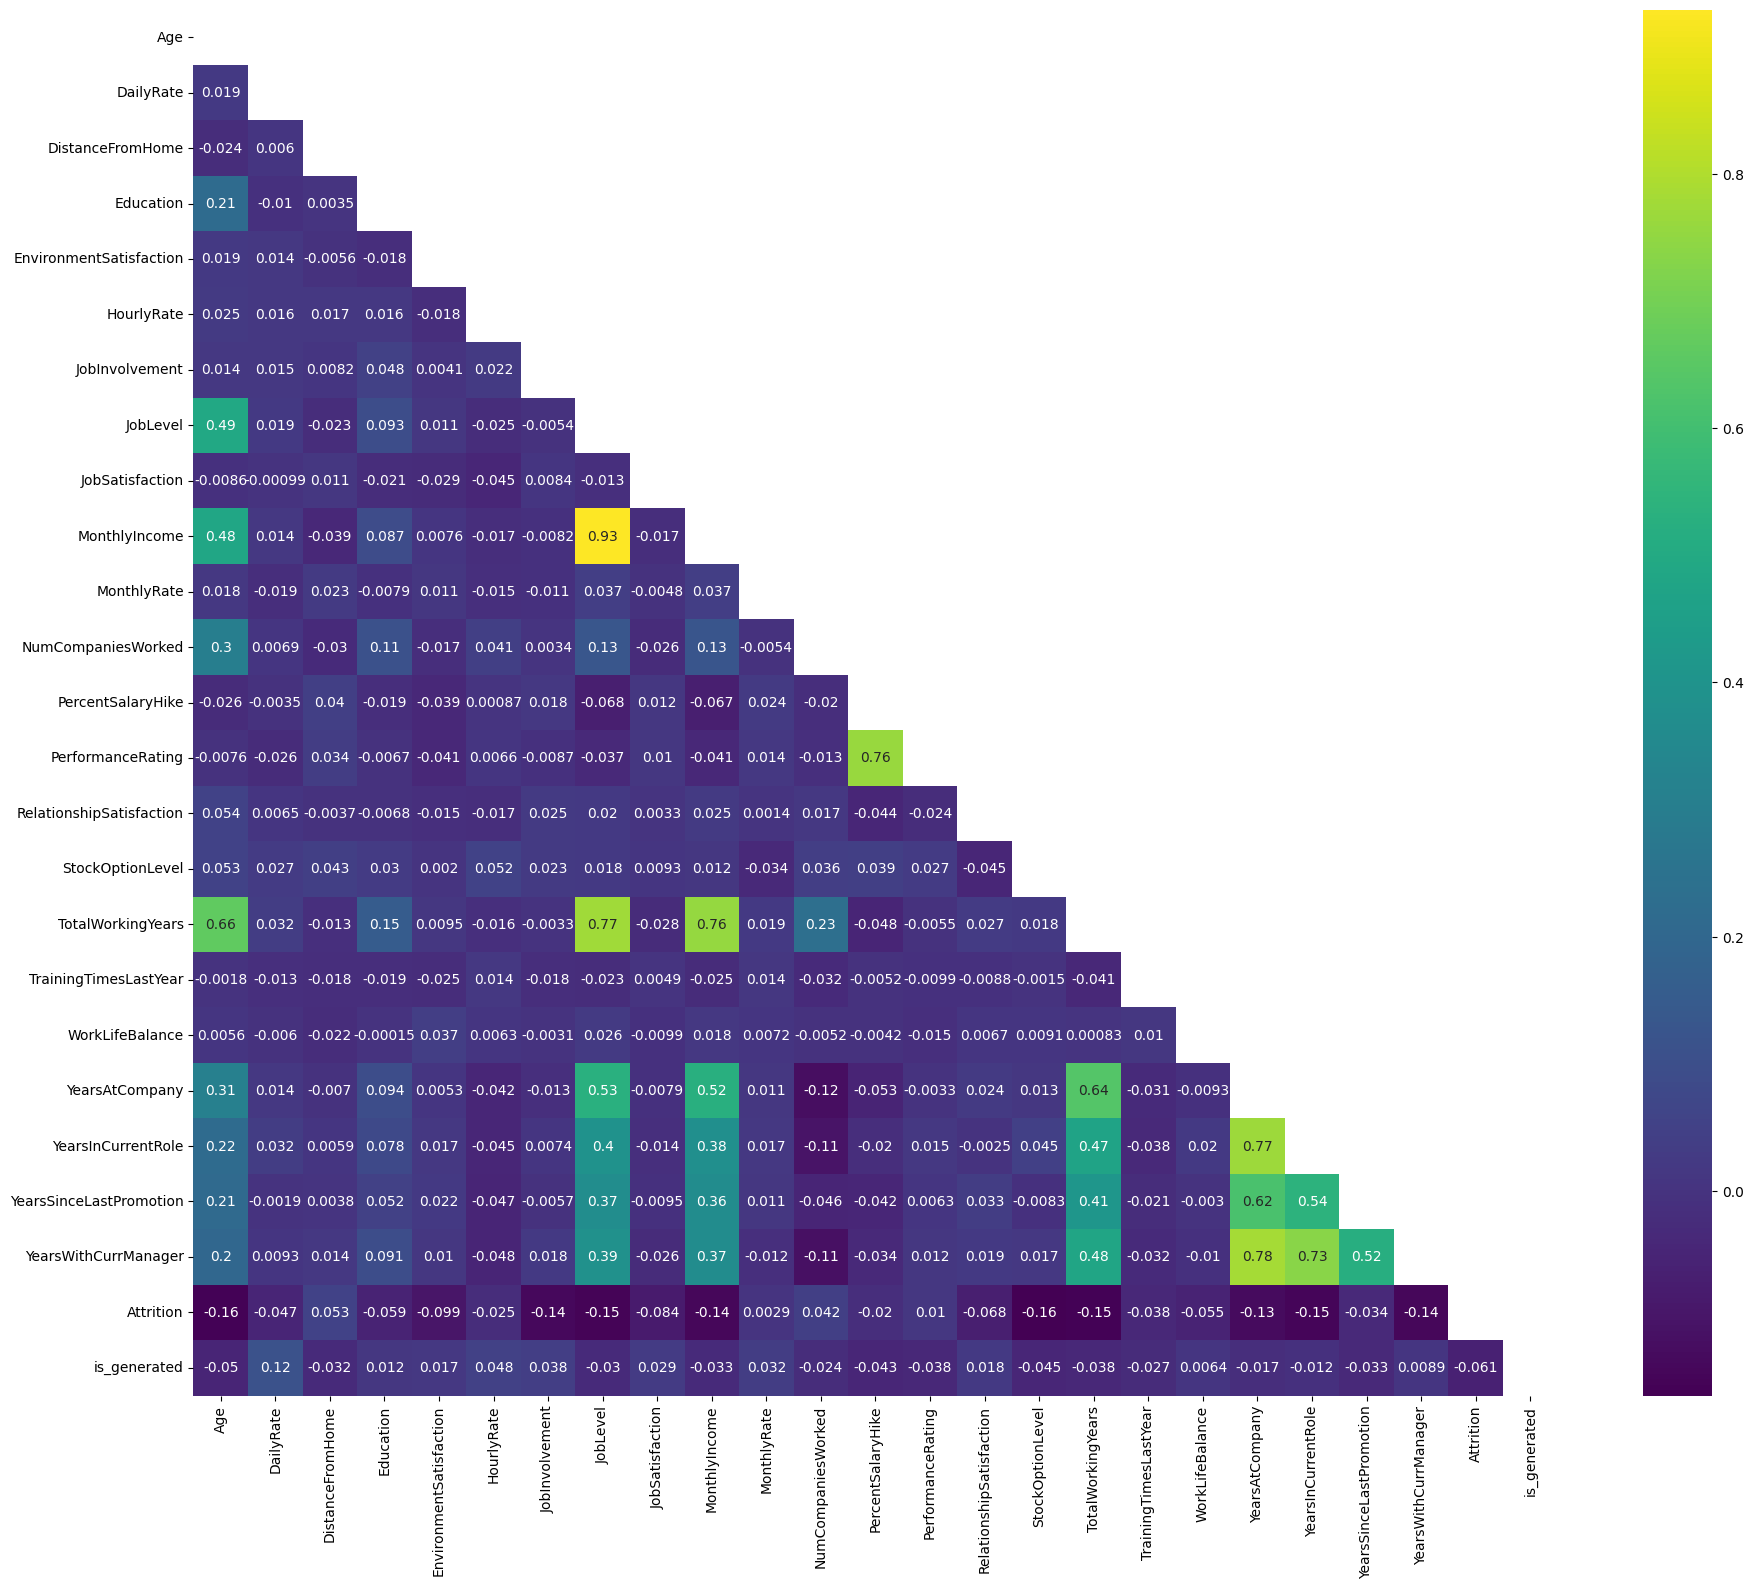

In [12]:
#Data Visualization
plt.figure(figsize=(22,18))
matrix = np.triu(train_df.corr())
sns.heatmap(train_df.corr(),annot=True,mask=matrix,cmap='viridis')

In [13]:
feats_to_drop = [col for col in train_df.columns if train_df[col].nunique()==1]
cat_features = [col for col in train_df.columns if train_df[col].nunique() <= 20 and train_df[col].nunique() > 1]

train_df.drop(columns=feats_to_drop, inplace=True)

In [14]:
x_full = train_df.copy()
y_full = x_full.pop('Attrition').to_numpy()


num_cols = x_full.select_dtypes(exclude="object").columns
print(num_cols)
cat_cols = x_full.columns.difference(num_cols)
print(cat_cols)

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

tr = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", OrdinalEncoder(), cat_cols),
])

x_full = tr.fit_transform(x_full)
x_test = tr.transform(test_df)

print("train shape = ", x_full.shape)
print("test shape = ", x_test.shape)

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'is_generated'],
      dtype='object')
Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')
train shape =  (3147, 31)
test shape =  (1119, 31)


In [15]:
#Training
models = []
def validate(X, y, X_test, model, catboost=False):
    score_list, oof_pred = [], []
    kf = StratifiedKFold(n_splits=12, random_state=42, shuffle=True)
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        print(f"Fold {fold} validating...")
        if catboost:
            model.fit(X_train, y_train, verbose=False)
        else:
            model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:,1]
        oof_pred.append(model.predict_proba(X_test)[:,1])
        score = roc_auc_score(y_val, y_pred)
        score_list.append(score)
        models.append(model)
        print(f"AUC: {score:.4f}")
    print(f"Average AUC: {sum(score_list) / len(score_list):.4f}")
    return sum(oof_pred)/kf.get_n_splits()

In [16]:
catboost_params = {'loss_function': 'CrossEntropy',
                     'learning_rate': 0.76,
                     'l2_leaf_reg': 0.014,
                     'colsample_bylevel': 0.06,
                     'depth': 1,
                     'boosting_type': 'Plain',
                     'bootstrap_type': 'Bernoulli',
                     'min_data_in_leaf': 18,
                     'one_hot_max_size': 14,
                     'subsample': 0.99}

catboost_clf = catboost.CatBoostClassifier(**catboost_params)
validate(x_full, y_full, x_test, catboost_clf, catboost=True)

Fold 0 validating...
AUC: 0.8701
Fold 1 validating...
AUC: 0.8814
Fold 2 validating...
AUC: 0.8372
Fold 3 validating...
AUC: 0.8995
Fold 4 validating...
AUC: 0.8831
Fold 5 validating...
AUC: 0.8546
Fold 6 validating...
AUC: 0.8607
Fold 7 validating...
AUC: 0.8823
Fold 8 validating...
AUC: 0.8183
Fold 9 validating...
AUC: 0.7716
Fold 10 validating...
AUC: 0.8635
Fold 11 validating...
AUC: 0.8079
Average AUC: 0.8525


array([0.06008563, 0.13230323, 0.00484261, ..., 0.00851968, 0.02765636,
       0.0007082 ])

In [17]:
#Submission
submission = pd.read_csv("/kaggle/input/playground-series-s3e3/sample_submission.csv")

In [18]:
test_preds = []

for model in models:
    preds = model.predict_proba(x_test)
    test_preds.append(preds[:, 1])
    
test_preds = np.stack(test_preds).mean(0)
test_preds

array([0.06137031, 0.10438867, 0.00469215, ..., 0.00636153, 0.03215089,
       0.0002916 ])

In [19]:
submission['Attrition'] = test_preds
submission.head()

,id,Attrition
0,1677,0.061370
1,1678,0.104389
2,1679,0.004692
3,1680,0.039490
4,1681,0.384834


<AxesSubplot: >

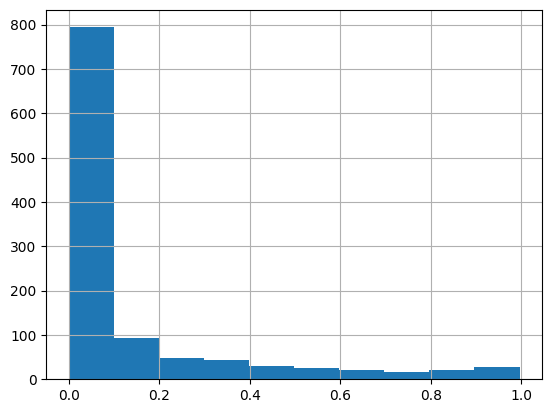

In [20]:
submission['Attrition'].hist()

In [21]:
submission.to_csv('submission.csv', index=False)